<a href="https://www.kaggle.com/code/aniruddhapa/classify-blood-clot-origin-in-ischemic-stroke?scriptVersionId=120822974" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<html>
    <body>
        <center>
    <font color="Blue">
    <H1>Predict Blood Clot Origins In Ischemic Stroke</H1> 
    <h2>[CE (Cardioembolic) or LAA (Large Artery Atherosclerosis)]</h2>
    <h4>The purpose of this notebook is to enable healthcare providers to better identify the origins of blood clots in deadly strokes, making it easier for physicians to prescribe the best post-stroke therapeutic management and reducing the likelihood of a second stroke.</h4>
        </center></body></html>     

In [1]:
import gc
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.models
from tensorflow.keras.layers  import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
# import openslide
# from openslide import OpenSlide
# from openslide import open_slide
# from openslide.deepzoom import DeepZoomGenerator
# import cv2 as cv
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
#importing training dataset
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [3]:
#importing test dataset
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
test_df.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


In [4]:
# Adding a new column called "file_path" to "test_df" and populating it with the file paths of 
# image files inside input/mayo-clinic-strip-ai/test folder.

test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")
test_df.head()

,image_id,center_id,patient_id,image_num,file_path
0,006388_0,11,006388,0,../input/mayo-clinic-strip-ai/test/006388_0.tif
1,008e5c_0,11,008e5c,0,../input/mayo-clinic-strip-ai/test/008e5c_0.tif
2,00c058_0,11,00c058,0,../input/mayo-clinic-strip-ai/test/00c058_0.tif
3,01adc5_0,11,01adc5,0,../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [5]:
#creating a target column in training set and assigning values '0' and '1' for both the labels
train_df['target']=train_df['label'].apply(lambda x:1 if x=='CE' else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,target
0,006388_0,11,006388,0,CE,1
1,008e5c_0,11,008e5c,0,CE,1
2,00c058_0,11,00c058,0,LAA,0
3,01adc5_0,11,01adc5,0,LAA,0
4,026c97_0,4,026c97,0,CE,1


# Preparing the training dataset

In [6]:
'''The following code collects the file paths for all files in the 'CE' directory and its subdirectories 
and stores them in an empty list called 'x_train'''

x_train=[]
for path, subdirs,files in os.walk('../input/mayo-clinic/First Experiment/train/CE'):
    for name in files:
        x_train.append(os.path.join(path,name))

In [7]:
''' Creating a dataframe df with 2 columns 'filepath' and 'label'. Populating 'filepath' column
with actual filepath from x_train list'''

df=pd.DataFrame()
df['filepath']=x_train
df['label']='CE'

In [8]:
# df looks like this at this stage
df.head()

,filepath,label
0,../input/mayo-clinic/First Experiment/train/CE...,CE
1,../input/mayo-clinic/First Experiment/train/CE...,CE
2,../input/mayo-clinic/First Experiment/train/CE...,CE
3,../input/mayo-clinic/First Experiment/train/CE...,CE
4,../input/mayo-clinic/First Experiment/train/CE...,CE


In [9]:
'''The following code collects the file paths for all files in the 'LAA' directory and its subdirectories 
and stores them in an empty list called 'x_train'''

x_train=[]
for path, subdirs,files in os.walk('../input/mayo-clinic/First Experiment/train/LAA'):
    for name in files:
        x_train.append(os.path.join(path,name))

In [10]:
#storing the filepath and label in df1

df1=pd.DataFrame()
df1['filepath']=x_train
df1['label']='LAA'

In [11]:
# Merging df and df1 , storing the content inside new Dataframe train_df

train_df=df.append(df1)

In [12]:
train_df=train_df.reset_index()

In [13]:
train_df.drop(['index'],axis=1,inplace=True)

In [14]:
train_df['target']=train_df['label'].apply(lambda x:1 if x=='CE' else 0)

In [15]:
train_df.shape

(124837, 3)

In [16]:
train_df.label.value_counts()

CE     81630
LAA    43207
Name: label, dtype: int64

In [17]:
pd.set_option('display.max_colwidth', None)

In [18]:
train_df.to_csv('train.csv',index=False)

In [19]:
train_df.memory_usage(index=False)

filepath    998696
label       998696
target      998696
dtype: int64

In [20]:
train_df.head()

,filepath,label,target
0,../input/mayo-clinic/First Experiment/train/CE/d53ab7_0_19_21_17.png,CE,1
1,../input/mayo-clinic/First Experiment/train/CE/3d10be_2_6_7_15.png,CE,1
2,../input/mayo-clinic/First Experiment/train/CE/0b7871_0_5_20_15.png,CE,1
3,../input/mayo-clinic/First Experiment/train/CE/b894f4_0_33_110_17.png,CE,1
4,../input/mayo-clinic/First Experiment/train/CE/45e3e0_0_10_9_16.png,CE,1


# Preparing the image array

In [21]:
ls

__notebook__.ipynb  train.csv


In [22]:
# Importing the training .csv file created earlier into a new dataframe df
import pandas as pd
df=pd.read_csv('train.csv')

In [23]:
df.shape

(124837, 3)

In [24]:
df.head()

,filepath,label,target
0,../input/mayo-clinic/First Experiment/train/CE/d53ab7_0_19_21_17.png,CE,1
1,../input/mayo-clinic/First Experiment/train/CE/3d10be_2_6_7_15.png,CE,1
2,../input/mayo-clinic/First Experiment/train/CE/0b7871_0_5_20_15.png,CE,1
3,../input/mayo-clinic/First Experiment/train/CE/b894f4_0_33_110_17.png,CE,1
4,../input/mayo-clinic/First Experiment/train/CE/45e3e0_0_10_9_16.png,CE,1


In [25]:
# Creating to variables to store no. of rows in each label

class_ce,class_laa=df.label.value_counts()

In [26]:
class_ce

81630

In [27]:
class_laa

43207

In [28]:
# Creating 2 seperate dataframes for both the labels
df_class_ce=df[df['label']=='CE']
df_class_laa=df[df['label']=='LAA']

In [29]:
df_class_ce.shape

(81630, 3)

**class CE has 81630 records and class LAA has 43207 records.**

**Class CE almost has double amount of records than LAA, which is a case of Imbalanced Dataset.**

### What is imbalanced data and how to handle imbalanced dataset?

Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations. We can better understand imbalanced dataset handling with an example.

**Example**

Let’s assume that XYZ is a bank that issues a credit card to its customers. Now the bank is concerned that some fraudulent transactions are going on and when the bank checks their data they found that for each 2000 transaction there are only 30 Nos of fraud recorded. So, the number of fraud per 100 transactions is less than 2%, or we can say more than 98% transaction is “No Fraud” in nature. Here, the class “No Fraud” is called the majority class, and the much smaller in size “Fraud” class is called the minority class.

### Resampling(Oversampling and Undersampling)

This technique is used to upsample or downsample the minority or majority class. When we are using an imbalanced dataset, we can oversample the minority class using replacement. This technique is called oversampling. Similarly, we can randomly delete rows from the majority class to match them with the minority class which is called undersampling. After sampling the data we can get a balanced dataset for both majority and minority classes. So, when both classes have a similar number of records present in the dataset, we can assume that the classifier will give equal importance to both classes.

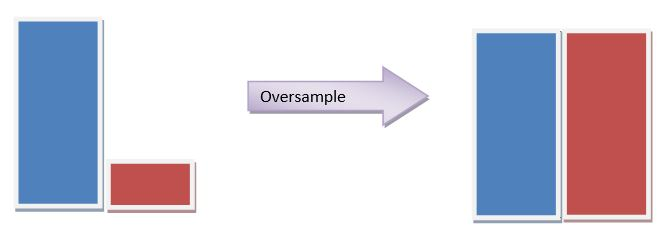

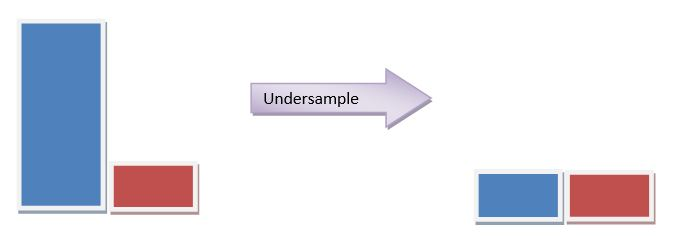

**Here ,we will oversample the minority class with duplicate synthetic records, i.e LAA and we will undersample the majority class i.e CE.**

In [30]:
df_class_laa_over=df_class_laa.sample(3000,replace=True)

In [31]:
df_class_ce=df_class_ce.sample(3000)

In [32]:
df_class_ce.label.value_counts()

CE    3000
Name: label, dtype: int64

In [33]:
df_class_laa_over.label.value_counts()

LAA    3000
Name: label, dtype: int64

In [34]:
# Revised dataset with equal no. of records of both the classes
df=pd.concat([df_class_ce,df_class_laa_over],axis=0)
df.label.value_counts()

CE     3000
LAA    3000
Name: label, dtype: int64

In [35]:
df=df.reset_index()
df.head(10)

,index,filepath,label,target
0,75609,../input/mayo-clinic/First Experiment/train/CE/c32d76_0_33_4_16.png,CE,1
1,76491,../input/mayo-clinic/First Experiment/train/CE/4f6fb1_2_5_13_16.png,CE,1
2,6386,../input/mayo-clinic/First Experiment/train/CE/13f372_0_34_106_17.png,CE,1
3,21000,../input/mayo-clinic/First Experiment/train/CE/e96bd3_0_6_37_16.png,CE,1
4,18766,../input/mayo-clinic/First Experiment/train/CE/c3a1a5_0_4_12_14.png,CE,1
5,56415,../input/mayo-clinic/First Experiment/train/CE/cb2534_1_33_6_15.png,CE,1
6,34427,../input/mayo-clinic/First Experiment/train/CE/9f0f05_0_10_12_16.png,CE,1
7,7807,../input/mayo-clinic/First Experiment/train/CE/634e2f_0_26_15_17.png,CE,1
8,57070,../input/mayo-clinic/First Experiment/train/CE/868720_0_19_58_16.png,CE,1
9,81618,../input/mayo-clinic/First Experiment/train/CE/5c92f8_0_11_8_16.png,CE,1


In [36]:
df.drop(['index'],axis=1,inplace=True)

In [37]:
# print("Max",train_data.max())
# print("Min",train_data.min())
# print("Datatype Before",train_data.dtype)
# print("Size in byte Before",train_data.nbytes)
# train_data=train_data.astype('float16')
# print(train_data.dtype)
# print(train_data.nbytes)
# print(train_data.shape)
# print(train_data.size)

In [38]:
import gc
gc.collect()

178

In [39]:
df.shape

(6000, 3)

In [40]:
pd.set_option('display.max_colwidth', None)

In [41]:
df.sample(10)

,filepath,label,target
1287,../input/mayo-clinic/First Experiment/train/CE/a2b566_0_10_17_16.png,CE,1
932,../input/mayo-clinic/First Experiment/train/CE/b07b42_0_3_73_17.png,CE,1
386,../input/mayo-clinic/First Experiment/train/CE/049194_1_17_10_16.png,CE,1
3472,../input/mayo-clinic/First Experiment/train/LAA/d6525e_0_4_12_17.png,LAA,0
3726,../input/mayo-clinic/First Experiment/train/LAA/eb21f0_0_10_7_16.png,LAA,0
2469,../input/mayo-clinic/First Experiment/train/CE/83cedb_0_20_31_17.png,CE,1
2594,../input/mayo-clinic/First Experiment/train/CE/6747be_0_5_3_16.png,CE,1
3582,../input/mayo-clinic/First Experiment/train/LAA/6015f7_0_0_26_16.png,LAA,0
3098,../input/mayo-clinic/First Experiment/train/LAA/15de51_0_16_5_15.png,LAA,0
4901,../input/mayo-clinic/First Experiment/train/LAA/300145_0_10_21_15.png,LAA,0


In [42]:
# Now we are taking the list of image file paths, loading each image, resizing it, 
# and storing it inside X_train list.

from PIL import Image
import csv
X_train=[]
for i in tqdm(df['filepath']):
    image=Image.open(i)
    image = tf.image.resize(image,(224, 224))
    image = np.array(image)
#     image=image.astype('float16')
#     image=image/255
    X_train.append(image)

100%|██████████| 6000/6000 [03:08<00:00, 31.82it/s]


In [43]:
# Converting the list to numpy array
X_train=np.array(X_train)

In [44]:
type(X_train)

numpy.ndarray

In [45]:
type(X_train[0][0][0][0])


numpy.float32

In [46]:
# Converting the datatype from float64 to uint8, as it is more memory efficient.

print("Max",X_train.max())
print("Min",X_train.min())
print("Datatype Before",X_train.dtype)
print("Size in byte Before",X_train.nbytes)
X_train=X_train.astype('uint8')
print(X_train.dtype)
print(X_train.nbytes)
print(X_train.shape)
print(X_train.size)

Max 255.0
Min 0.0
Datatype Before float32
Size in byte Before 4816896000
uint8
1204224000
(6000, 224, 224, 4)
1204224000


In [47]:
# Preparing the y_train from 'target' column
y_train=df['target'][:6000]

### Creating convolutional neural network (CNN) model using the Keras API within TensorFlow

- The Sequential() function initializes an empty sequential model object that we can add layers to sequentially.

- The next line input_shape=(224,224,4) defines the shape of the input images that will be fed into the model. 

- The input shape is a 224x224 RGB image (3 channels for red, green, and blue) with an additional channel that is not specified.

- The next few lines add convolutional layers to the model using the Conv2D() function. 

- The first layer has 32 filters of size 3x3, a stride of 2, 'same' padding, and uses the ReLU activation function. 

- The input shape is specified using the input_shape variable defined earlier. 

- The subsequent layers are similar, with 64 and 32 filters respectively.

- The Flatten() layer flattens the output of the convolutional layers into a 1D array.

- The next line model.add(Dense(128,activation='relu')) adds a fully connected layer with 128 units and a ReLU activation function.

- The Dropout(0.25) layer applies dropout regularization to the previous layer, randomly dropping out 25% of the inputs during training to prevent overfitting.

- The final Dense(1) layer is the output layer of the model, with a single output unit that will predict a numerical value.

- The model.compile() function compiles the model, specifying the loss function, metrics to evaluate during training, and optimizer to use during training. In this case, the mean squared error loss function is used, along with the root mean squared error, mean absolute error, and mean absolute percentage error as evaluation metrics. The Adam optimizer with a learning rate of 1e-3 is used to update the model parameters during training.

In [48]:
model=keras.Sequential()
input_shape=(224,224,4)

model.add(Conv2D(filters=32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(1))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mae','mape'],
    optimizer=tf.keras.optimizers.Adam(1e-3))

> Overall, the above code defines a relatively simple CNN model for regression tasks, consisting of convolutional and fully connected layers with ReLU activation functions, dropout regularization, and a single output unit with mean squared error loss. 

In [49]:
model

In [50]:
y_train.shape

(6000,)

In [51]:
x_train,x_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2)

## Training the Model

In [52]:
%%time

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping,Callback

'''The step_decay function defines a learning rate schedule that decreases the learning rate by a factor 
of 0.5 every 10 epochs. It takes an argument epoch that represents the current epoch number, and returns 
the updated learning rate for that epoch.'''

def step_decay(epoch):
    initial_lrate=0.001
    drop=0.5
    epochs_drop=10.0
    lrate=initial_lrate * math.pow(drop,math.floor((epoch)/epochs_drop))
    return lrate

'''The LearningRateScheduler callback is created with the step_decay function, 
and will update the learning rate at the beginning of each epoch during training.'''

lrate=LearningRateScheduler(step_decay)

'''The EarlyStopping callback is also created to monitor the validation loss during training, and stop 
training if the validation loss does not improve for 5 consecutive epochs.'''

earstop=EarlyStopping(monitor='val_loss',min_delta=0,patience=5)

'''The model.fit() method is used to train the model. It takes the training data x_train and y_train, 
as well as the number of epochs, batch size, and validation data x_test and y_test. The callbacks 
parameter is set to a list of the two previously created callbacks: lrate and earstop.'''

history=model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_test,y_test),
    verbose=1,
    callbacks=[lrate,earstop]
)

Epoch 1/50
75/75 [==============================] - 11s 42ms/step - loss: 31425.2793 - rmse: 177.2718 - mae: 29.2249 - mape: 15747143680.0000 - val_loss: 0.2866 - val_rmse: 0.5353 - val_mae: 0.4957 - val_mape: 169809600.0000 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 3s 34ms/step - loss: 0.2847 - rmse: 0.5335 - mae: 0.4865 - mape: 215490288.0000 - val_loss: 0.2594 - val_rmse: 0.5093 - val_mae: 0.4878 - val_mape: 238303376.0000 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 2s 33ms/step - loss: 0.2696 - rmse: 0.5192 - mae: 0.4860 - mape: 224006160.0000 - val_loss: 0.2544 - val_rmse: 0.5044 - val_mae: 0.4910 - val_mape: 256813680.0000 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 2s 33ms/step - loss: 0.2593 - rmse: 0.5093 - mae: 0.4786 - mape: 222990448.0000 - val_loss: 0.2558 - val_rmse: 0.5058 - val_mae: 0.4907 - val_mape: 275215584.0000 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 2s 32ms/step - loss: 0.253

In [53]:
# Garbage Collection to free up memory not in use
gc.collect()

1482

In [54]:
# Test Dataset
test_df.head()

,image_id,center_id,patient_id,image_num,file_path
0,006388_0,11,006388,0,../input/mayo-clinic-strip-ai/test/006388_0.tif
1,008e5c_0,11,008e5c,0,../input/mayo-clinic-strip-ai/test/008e5c_0.tif
2,00c058_0,11,00c058,0,../input/mayo-clinic-strip-ai/test/00c058_0.tif
3,01adc5_0,11,01adc5,0,../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [55]:
'''The purpose of this function is to preprocess an image file located at image_path'''

def preprocess(image_path):
    
    '''This line uses the OpenSlide library to open the image file located at image_path and create a slide object that represents the whole image'''
    
    slide=OpenSlide(image_path)
    
    '''This line sets the region variable to a tuple representing the top-left corner of a rectangular 
    region of the image that we want to extract. In this case, the region starts 1000 pixels to the right
    and 1000 pixels down from the top-left corner of the image.'''
    
    region= (1000,1000)    
    
    '''This line sets the size variable to a tuple representing the width and height of the rectangular 
    region that we want to extract. In this case, the region has a width and height of 5000 pixels.'''
    
    size  = (5000, 5000)
    
    '''This line extracts the rectangular region specified by region and size from the slide object using
    the read_region method. The third argument (0) specifies the level of the image pyramid to use, where 
    0 means the original full-resolution image.'''
    
    image = slide.read_region(region, 0, size)
    
    '''This line uses TensorFlow's tf.image.resize function to resize the extracted region to a smaller 
    size of (224, 224). This is a common size used by many neural networks for image classification.'''
    
    image = tf.image.resize(image, (224, 224))
    
    image = np.array(image)    
    return image

In [56]:
import openslide #import openslide library for reading whole-slide images.
from openslide import OpenSlide # import OpenSlide Class open and extract regions.
from openslide import open_slide # import open_slide function

'''This line imports the DeepZoomGenerator class from the openslide.deepzoom module, which provides a way
to generate a tiled pyramid of images from a whole-slide image.'''

from openslide.deepzoom import DeepZoomGenerator 

test1=[]# to store pre-processed image

for i in tqdm(test_df['file_path']):
    x1=preprocess(i)
    test1.append(x1)
    gc.collect()
test1=np.array(test1)

100%|██████████| 4/4 [00:19<00:00,  4.97s/it]


In [57]:
# test1=test1/255

In [58]:
test1.shape

(4, 224, 224, 4)

In [59]:
# Predict the test dataset using the model
cnn_pred=model.predict(test1)
cnn_pred

1/1 [==============================] - 0s 114ms/step


array([[0.92539304],
       [1.1912264 ],
       [0.80818   ],
       [0.46993864]], dtype=float32)

In [60]:
# creating the dataframe to generate submission file

sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["CE"] = sub["CE"].apply(lambda x : 0 if x<0 else x)
sub["CE"] = sub["CE"].apply(lambda x : 1 if x>1 else x)
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()

sub

,patient_id,CE,LAA
0,006388,0.925393,0.074607
1,008e5c,1.000000,0.000000
2,00c058,0.808180,0.191820
3,01adc5,0.469939,0.530061


In [61]:
# storing the submission df to .csv file.
sub.to_csv("submission.csv", index = False)
!head submission.csv


patient_id,CE,LAA
006388,0.925393,0.074607
008e5c,1.0,0.0
00c058,0.80818,0.19182
01adc5,0.469939,0.530061
